# LT2316 H20 Assignment B - image autoencoder

## Introduction

In this assignment, you will define an image autoencoder model by changing/adding a limited amount of code to this notebook.  We will mark off what you will change.  

An autoencoder is a machine learning system/network that attempts to reconstruct the input (or a proxy for the input such as its context, as in neural language modeling) after compressing it to a smaller "bottleneck" representation. We can then extract the compressed representation for the input by running the input through the part of the trained model that ends in the compressing hidden layer.  For images, the input and output of the full model usually have the same shape, and the loss is the pixel-by-pixel colour channel error.  The embeddings of the images are extracted from some middle layer as a vector of much lower dimensionality.

We can then examine how "good" the embeddings are not only by the training loss but also by other techniques, such as clustering the embeddings. We will just test on the training data for simplicity (this is not always wrong if our goal is merely to get a generalized/compressed representation of a fixed amount of data).

Below we will mark off what you need to change and what you can change in markdown and code comments. The rest should remain untouched when you submit.  You are recommended to develop in a copy of the notebook you will submit and then port over your changes to the "final" notebook. That way, you can modify our code to test your code in your private notebook.

You will submit a saved notebook directly to Canvas.  

## Loading the data

In [1]:
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import random 
from PIL import Image
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
# You may add imports you feel you need for the notebook

In [2]:
%matplotlib inline

In [3]:
coco = COCO(annotation_file="/scratch/lt2316-h18-resources/coco/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=18.78s)
creating index...
index created!


In [4]:
my_device = "cuda:1" # you can change the device to another GPU or the cpu for testing

In [5]:
def get_data(meta, datadir="/scratch/lt2316-h18-resources/coco/train2017"):
    return [(x['file_name'], Image.open("{}/{}".format(datadir, x['file_name'])).resize((100,100)).convert('RGB')) for x in meta]

def cat_img_load(category, coco, trainsize):
    catids = coco.getCatIds(catNms=category)
    imgids = coco.getImgIds(catIds=catids)
    
    random.shuffle(imgids)
    imgids = imgids[:trainsize]
    imgmeta = coco.loadImgs(ids=imgids)
    imgdata = get_data(imgmeta)
    
    imgdf = pd.DataFrame()
    imgnames = [x[0] for x in imgdata]
    imgarrays = [x[1] for x in imgdata]
    imgdf['imgs'] = imgarrays
    imgdf['filename'] = imgnames
    imgdf['class'] = category
    
    return imgdf

def get_tensors(*imgdfs):
    bigdf = pd.concat(imgdfs)
    print(len(bigdf))
    X = np.array([np.array(x) for x in bigdf['imgs']])
    print(X.shape)
    y = bigdf['class']
    filenames = bigdf['filename']
    X_scaled = StandardScaler().fit_transform(X.reshape(len(X),30000)).reshape(len(X), 100, 100, 3)
    X_tensor = torch.Tensor(X_scaled).to(my_device)
    return X_tensor, y, filenames

**We may change these MS COCO categories when testing as well as the number of retrieved items.**

In [6]:
airplanedf = cat_img_load("airplane", coco, 1000)
skateboarddf = cat_img_load("skateboard", coco, 1000)
mousedf = cat_img_load("mouse", coco, 1000)

In [7]:
len(airplanedf), len(skateboarddf), len(mousedf)

(1000, 1000, 1000)

In [8]:
X_tensor, y, filenames = get_tensors(airplanedf, skateboarddf, mousedf)

3000
(3000, 100, 100, 3)


## Batching and shuffling

**There should be no reason to edit this.**

In [9]:
class Batcher:
    def __init__(self, X, device, batch_size=50, max_iter=None):
        self.X = X
        self.device = device
        self.batch_size=batch_size
        self.max_iter = max_iter
        self.curr_iter = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.curr_iter == self.max_iter:
            raise StopIteration
        permutation = torch.randperm(self.X.size()[0], device=self.device)
        permX = self.X[permutation]
        splitX = torch.split(permX, self.batch_size)
        
        self.curr_iter += 1
        return splitX

## Autoencoder

**Here is where you will make the main changes.**

You will get **10 points** for making changes that run and produce representations that are *emb_size* in width when we extract the embeddings by calling *emb* on the training data and represent a good-faith attempt at building a simple autoencoder.  

We will give **1 to 3 points** for model design.

In [10]:
class ImageAutoencoder(nn.Module):
    # You may ADD hyperparameters here (and make requisite adaptations in the training loop below).
    # Document them under "Your analysis"
    def __init__(self, emb_size, height, width):
        super(ImageAutoencoder, self).__init__()
        self.emb_size = emb_size
        self.height = height
        self.width = width
        
        #input_size = height*width*3
        input_size = width * 3
        #input_size = 3
        
        # Define your network structure here using PyTorch.
        self.enc1 = nn.Linear(in_features=input_size, out_features=input_size//2)
        self.enc2 = nn.Linear(in_features=input_size//2, out_features=input_size//4)
        self.enc3 = nn.Linear(in_features=input_size//4, out_features=emb_size)
        self.dec1 = nn.Linear(in_features=emb_size, out_features=input_size//4)
        self.dec2 = nn.Linear(in_features=input_size//4, out_features=input_size//2)
        self.dec3 = nn.Linear(in_features=input_size//2, out_features=input_size)
        
        
    def forward(self, batch):
        # Apply the model to the batch here.  Watch out for the shapes!
        batch = batch.flatten(start_dim=2)
        
        en1 = self.enc1(batch)
        en1 = torch.relu(en1)
        en2 = self.enc2(en1)
        en2 = torch.relu(en2)
        en3 = self.enc3(en2)
        en3 = torch.relu(en3)
        de1 = self.dec1(en3)
        de1 = torch.relu(de1)
        de2 = self.dec2(de1)
        de2 = torch.relu(de2)
        de3 = self.dec3(de2)
        de3 = torch.relu(de3)
        
        out = de3.view(-1, self.height, self.width, 3)
    
        return out
        
    def emb(self, batch):
        # This should return the inner representation of the images, including for arbitrary unseen images
        # of the correct shape.
        batch = batch.flatten(start_dim=2)
        en1 = self.enc1(batch)
        en1 = torch.relu(en1)
        en2 = self.enc2(en1)
        en2 = torch.relu(en2)
        en3 = self.enc3(en2)
        en3 = torch.relu(en3)
        
        out = en3.view(-1, self.height, self.emb_size)
        out = out.flatten(start_dim=1)
        return out

In [11]:
class ImageAutoencoderCNN(nn.Module):
    # You may ADD hyperparameters here (and make requisite adaptations in the training loop below).
    # Document them under "Your analysis"
    def __init__(self, emb_size, height, width):
        super(ImageAutoencoderCNN, self).__init__()
        self.emb_size = emb_size
        self.height = height
        self.width = width
        
        self.c1 = nn.Conv2d(3, 3, 3, padding=True)
        self.lin1 = nn.Linear(height * width * 3, emb_size)
        self.lin2 = nn.Linear(emb_size, height * width * 3)
        
        # Define your network structure here using PyTorch.
        
    def forward(self, batch):
        # Apply the model to the batch here.  Watch out for the shapes!
        switched = batch.permute(0, 3, 1, 2)
        x = self.c1(switched)
        x = x.reshape(-1, self.height * self.width * 3)
        x = self.lin1(x)
        x = self.lin2(x)
        x = x.reshape(-1, 3, self.height, self.width)
        x = self.c1(x)
        out = x.permute(0, 2, 3, 1)
        
        return out
    
#Dimensionen tauschen 
#Conv (3,3,3)
#Reshape
#Linear layer(30000,emb.)
#Decode:
#Linear layer(emb,30000)
#Reshape
#Conv1 layer (3,3,3)
#Dimensionen zurücksetzen

        
    def emb(self, batch):
        # This should return the inner representation of the images, including for arbitrary unseen images
        # of the correct shape.
        switched = batch.permute(0, 3, 1, 2)
        x = self.c1(switched)
        x = x.reshape(-1, self.height * self.width * 3)
        out = self.lin1(x)
        
        return out

## Training

In [12]:
import torch.optim as optim

**You may make limited changes here.**

You can adapt *train()* slightly to handle any hyperparameters you added to *ImageAutoencoder*.  We may test by changing the values of the hyperparameters when we grade the assignment.

In [13]:
def train(X, batch_size, epochs, device, model=None):
    b = Batcher(X, device, batch_size=batch_size, max_iter=epochs)
    if not model:
         #We may change the embedding size by hand here. 
        m = ImageAutoencoder(400, X[0].size()[0], X[0].size()[1]).to(device)
    else:
        m = model
    loss = nn.MSELoss()
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch = 0
    for split in b:
        tot_loss = 0
        for batch in split:
            optimizer.zero_grad()
            o = m(batch)
            l = loss(o, batch)
            tot_loss += l
            l.backward()
            optimizer.step()
        print("Total loss in epoch {} is {}.".format(epoch, tot_loss))
        epoch += 1
    return m

## Running the model and checking the output

We're leaving the results of running our own simple model here just so you know what it might look like, but there's no guarantee or requirement that the performance of your model will be similar.  It's reasonably likely that it might even be better...whatever we mean by better. But it will very likely be different, especially as there is some randomness involved.

In [14]:
#toy_tensor = X_tensor[:2]
model = train(X_tensor, 32, 100, my_device) 
# You can add hyperparameters also here, change the number of epochs, batch size, etc.

Total loss in epoch 0 is 73.03874206542969.
Total loss in epoch 1 is 65.2564468383789.
Total loss in epoch 2 is 62.95267105102539.
Total loss in epoch 3 is 61.592952728271484.
Total loss in epoch 4 is 60.98125457763672.
Total loss in epoch 5 is 60.22374725341797.
Total loss in epoch 6 is 59.841922760009766.
Total loss in epoch 7 is 59.29803466796875.
Total loss in epoch 8 is 58.94258117675781.
Total loss in epoch 9 is 58.67380905151367.
Total loss in epoch 10 is 58.54111099243164.
Total loss in epoch 11 is 58.37928009033203.
Total loss in epoch 12 is 58.249473571777344.
Total loss in epoch 13 is 58.29224395751953.
Total loss in epoch 14 is 57.95663833618164.
Total loss in epoch 15 is 58.13103485107422.
Total loss in epoch 16 is 58.00829315185547.
Total loss in epoch 17 is 57.6635627746582.
Total loss in epoch 18 is 57.60713577270508.
Total loss in epoch 19 is 57.7281608581543.
Total loss in epoch 20 is 57.38747024536133.
Total loss in epoch 21 is 57.350337982177734.
Total loss in epoch

In [15]:
everything = model(X_tensor)

In [16]:
everything.shape
#X_tensor.shape

torch.Size([3000, 100, 100, 3])

In [17]:
sample = everything[1507].cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


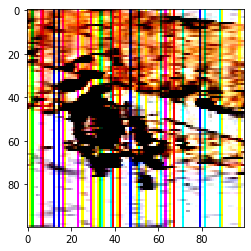

In [18]:
plt.imshow(sample)

In [19]:
sample_true = X_tensor[1507].cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


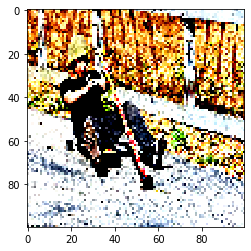

In [20]:
plt.imshow(sample_true)

In [21]:
embs = model.emb(X_tensor)

In [22]:
print(X_tensor.shape)
print(embs.shape)
#embs=embs.flatten(start_dim=1)  # cheating here, figure out what to do with dimensions!!
print(embs.shape)

torch.Size([3000, 100, 100, 3])
torch.Size([3000, 40000])
torch.Size([3000, 40000])


In [23]:
embs = embs.cpu().detach().numpy()

In [24]:
kmeans = KMeans(3, random_state=700).fit(embs)

In [25]:
kmeans.labels_

array([0, 2, 2, ..., 2, 2, 1], dtype=int32)

In [26]:
truncated = TruncatedSVD(2).fit_transform(embs)

In [27]:
truncated.shape

(3000, 2)

In [28]:
plt.rcParams['figure.figsize'] = (12,12)

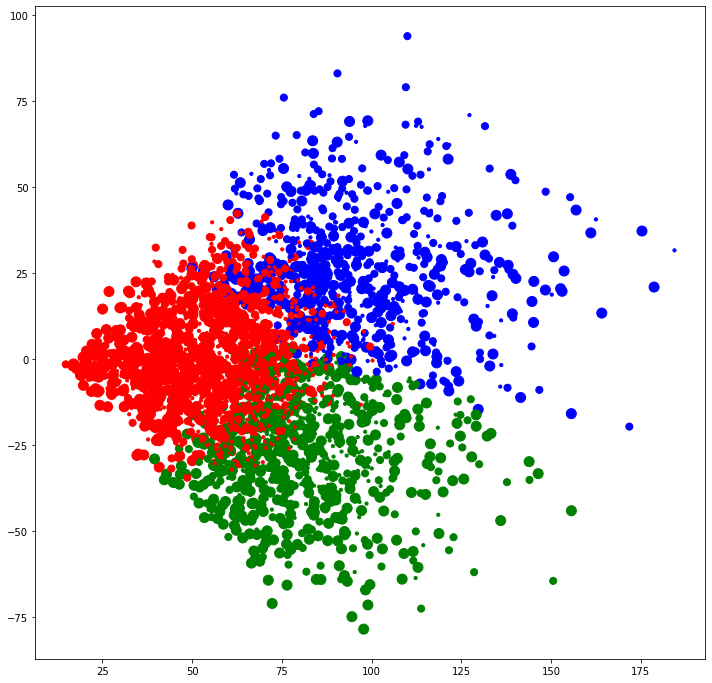

In [29]:
plt.scatter(truncated[:,0], truncated[:,1], c=[{0:'b',1:'g',2:'r'}[x] for x in kmeans.labels_], 
            s=[{"mouse":10, "skateboard":50, "airplane":100}[x] for x in y])

## Your analysis

**Informally analyze the performance of your model and clustering by examining cluster members to see the quality of the clusters and by experimenting with hyperparameters.  You can show your investigations here with markdown write-up.**

This will be graded on good-faith effort. **5 points** absolute for a reasonable effort (think 2-3 paragraphs of discussion and **3 points** used to identify effort quality.

I decided to use a chain of linear layers and ReLU non-linearitites for my autoencoder since I saw it suggested in several articles and it's a relatively straighforward approach. The parameters I'm going to change are input size, batch size, and number of epochs. Changing the input size of course changes the representation of the data to the neural network. I'll try it once with an input size of 3, representing the pixel layer, and once with an input size of 300, representing rows of pixels. I look at random images and their reconstructions for my analysis, as well as the cluster graph above.

For an input size of 300, batch size of 30, and 100 epochs, the reconstructed images include the correct shapes, and the overall color scheme is correct, but there are colored vertical lines running throughout the image. Since the clusters lie very close together, I'm struggling to see distinctive patterns there. Overall, the blue cluster tends to have many small points, and some medium ones, while the red one predominantly consists of medium ones, and the big dots cluster mainly in green. This suggests that the clustering can somewhat distinguish between mice, skateboards, and planes, but the grouping is not very clear. There is significant overlap between the clusters, indicating that the model is not very successful at encoding the relevant information.

Using the same input size and batch size, but a significantly lower number of epochs (20) unsurprisingly yields worse results. The images still broadly contain the same shapes, but the colors are completely off and there are even more of the stripes. In the cluster, the colors are distributed differently, and they are less clearly grouped. For example, the green cluster contains a semi-cluster of big points and directly next to it a semi-cluster of small points. The blue and red cluster seem to contain a mix of all three sizes. So 20 epochs obviously werent enough for the model to learn a good way of representing the images. 

In a third experiment, I used 100 epochs again and reduced the batch size to 5. The results with these hyperparameters are very similar to the ones with few epochs and larger batches, both in the images and in the cluster. 

When I change the input size to 3, with the same settings for batch size (30) and number of epochs (100), I get very interesting results. The images are reconstructed relatively accurately regarding the shapes of objects in them, but the colors are completely off (or yellow, to be more specific). This might also be caused by some error in my network though, maybe I accidentally switch the RBG values at some point. Looking at the cluster gives an even stranger sight. There are three clusters visible, but all the dots are big, so it seems like only pictures of airplanes are included in this clustering. Overall, it does not seem like the input size of 3 works well for this model and data (or I messed up the data when adjusting the layer sizes). 

I was surprised how good the results in the images were with the input size of 300, batch size 30, and 100 epochs since the model I chose is very simplistic. Even though the colourful stripes are not ideal of course, the motives of the pictures are still recognizable. However, they don't seem to be to the clustering algorithm, which inarguably doesn't do very well with the encoded data of my model. 

Out of curiosity, I played around with the embedding size too in the end, since the default of 400 seemed very high to me. However, I found out that the image quality significantly decreases with smaller embedding sizes and the clustering gets even less clear, with all three clusters overlapping in the middle of the graph. 

EDIT: Doing the bonus part, I got curious about trying another model for this task. The ImageAutoencoderCNN variant. I tried it with a few different batch sizes (5, 32, 64) and numbers of epochs (10, 20, 100, 200). All of these models are better at clustering in terms of producing clear groupings, but the point sizes are still somewhat randomly distributed (meaning that the groupings aren't very pure). This is confirmed by the corresponding scores in the bonus part. However, using a CNN gets rid of the vertical stripes in the image reconstructions described above and the images are generally closer to the originals in their color scheme and the shapes, even with the lower epoch numbers. 




## Your analysis (bonus)

**Search for an apply a method to analyze cluster purity relative to ground truth (4 bonus points), and apply it to hyperparameter and model variants (3 bonus points).**

In [30]:
from sklearn.metrics import homogeneity_score

score = homogeneity_score(y, kmeans.labels_)
score

0.03678664235869108

The homogeneity score was very low (around 0.03) for all hyperparameter variants of the linear model. Therefore, I decided to try another approach for this. Since convolutional neural networks are widely used for visual tasks, I implemented a simple CNN based on the cats and horses demo. The scores still aren't great, but there is a definite improvement over the linear models:

Linear, batch 32, epoch 100: 0.037

CNN, batch 32, epoch 100: 0.083

CNN, batch 64, epoch 200: 0.060

CNN, batch 32, epoch 300: 0.071



## Scratch area for your convenience

We will ignore anything after this line.